# Model 3: VGG19

## 1 Imports

In [1]:
import numpy as np 
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Dense, Dropout, Flatten
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
dir = '../../Data/Splitted_Images/'

train_dataset = image_dataset_from_directory(
    os.path.join(dir, "train"),
    image_size=(170, 256),
    batch_size=128)
validation_dataset = image_dataset_from_directory(
    os.path.join(dir, "val"),
    image_size=(170, 256),
    batch_size=128)
test_dataset = image_dataset_from_directory(
    os.path.join(dir, "test"),
    image_size=(170, 256),
    batch_size=128)

Found 3500 files belonging to 5 classes.
Found 750 files belonging to 5 classes.
Found 750 files belonging to 5 classes.


## 3 Training the model

In [3]:
conv_base = keras.applications.vgg19.VGG19(
    weights="imagenet",
    include_top=False,
)

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [4]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])


inputs = keras.Input(shape=(170, 256, 3))
x = data_augmentation(inputs) 
x = layers.Dropout(0.2)(x)
x = keras.applications.vgg19.preprocess_input(x) 
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs, outputs)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 170, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 170, 256, 3)       0         
                                                                 
 dropout (Dropout)           (None, 170, 256, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 170, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 170, 256, 3)      0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                             

In [6]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"]
)

callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="models/3_VGG19_Model.h5", save_best_only=True, monitor="val_loss"),
    EarlyStopping(monitor='val_loss', mode='auto', patience=5)  
    ]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/50
28/28 [==============================] - 49s 1s/step - loss: 10.3113 - accuracy: 0.3417 - val_loss: 3.7758 - val_accuracy: 0.4747
Epoch 2/50
28/28 [==============================] - 24s 833ms/step - loss: 4.0684 - accuracy: 0.4726 - val_loss: 1.9266 - val_accuracy: 0.6053
Epoch 3/50
28/28 [==============================] - 24s 850ms/step - loss: 2.6536 - accuracy: 0.5174 - val_loss: 1.4059 - val_accuracy: 0.6573
Epoch 4/50
28/28 [==============================] - 25s 894ms/step - loss: 1.8395 - accuracy: 0.5757 - val_loss: 1.0592 - val_accuracy: 0.7133
Epoch 5/50
28/28 [==============================] - 26s 915ms/step - loss: 1.4388 - accuracy: 0.6291 - val_loss: 0.8961 - val_accuracy: 0.7333
Epoch 6/50
28/28 [==============================] - 26s 906ms/step - loss: 1.1872 - accuracy: 0.6611 - val_loss: 0.7674 - val_accuracy: 0.7493
Epoch 7/50
28/28 [==============================] - 25s 896ms/step - loss: 1.0232 - accuracy: 0.6757 - val_loss: 0.8078 - val_accuracy: 0.7387
E

## 4 Plotting the training result

In [7]:
def plot_function(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "b", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

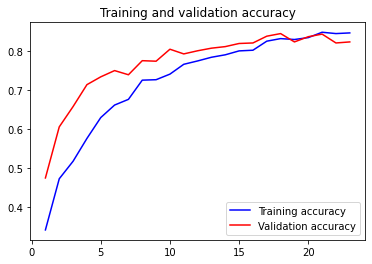

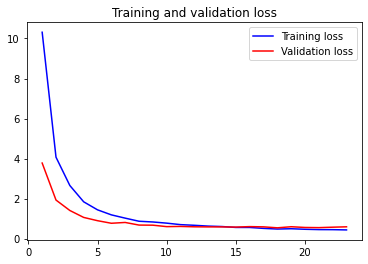

In [8]:
plot_function(history)

## 5 Testing the model on the testset

In [10]:
test_model = keras.models.load_model("models/3_VGG19_Model.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

6/6 [==============================] - 5s 668ms/step - loss: 0.5345 - accuracy: 0.8187
Test accuracy: 0.819
